# Library Imports

In [1]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

import talib as tb

--2023-06-01 07:50:19--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-01 07:50:19--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-06-01 07:50:19--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving nchc.dl.sourceforge.n

In [4]:
import talib as tb

In [5]:
import math
import pandas as pd
import numpy as np

from utils import *

import time
import datetime
from datetime import timezone

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
from statsmodels.tsa.arima_model import ARIMA

# Data Import

## Create DataFrame
### dataset_ex_df - APPL 5 min Dataset for 60 days from 2023-04-03

In [93]:
dataset_ex_df=pd.read_csv("/kaggle/input/stock-5min-data/AAPL_data_5min.csv")
dataset_ex_df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-04-03 13:30:00,164.270004,165.559998,164.220001,165.496704,165.496704,3833951
1,2023-04-03 13:35:00,165.494995,165.849899,165.360001,165.725006,165.725006,1398850
2,2023-04-03 13:40:00,165.732300,165.732300,165.440002,165.449997,165.449997,1077282
3,2023-04-03 13:45:00,165.440002,165.869995,165.229996,165.869995,165.869995,1138968
4,2023-04-03 13:50:00,165.869995,165.889999,165.270004,165.300003,165.300003,1160507


In [94]:
dataset_ex_df.shape

(3120, 7)

In [95]:
dataset_ex_df["Datetime"][0]

'2023-04-03 13:30:00'

# Data Visualization & Preprocess

In [96]:
close = dataset_ex_df["Adj Close"]
dataset_ex_df = dataset_ex_df.drop(columns=["Close","Adj Close"])
dataset_ex_df["Close"] = close
dataset_ex_df.head()

,Datetime,Open,High,Low,Volume,Close
0,2023-04-03 13:30:00,164.270004,165.559998,164.220001,3833951,165.496704
1,2023-04-03 13:35:00,165.494995,165.849899,165.360001,1398850,165.725006
2,2023-04-03 13:40:00,165.732300,165.732300,165.440002,1077282,165.449997
3,2023-04-03 13:45:00,165.440002,165.869995,165.229996,1138968,165.869995
4,2023-04-03 13:50:00,165.869995,165.889999,165.270004,1160507,165.300003


#### Add Log change and Percentage change of the Close price

In [97]:
dataset_ex_df['pct_change'] = (dataset_ex_df['Close'] - dataset_ex_df['Close'].shift(1))/ dataset_ex_df['Close'].shift(1)
dataset_ex_df['log_change'] = np.log(dataset_ex_df['Close']/ dataset_ex_df['Close'].shift(1))

In [98]:
dataset_ex_df.head()

,Datetime,Open,High,Low,Volume,Close,pct_change,log_change
0,2023-04-03 13:30:00,164.270004,165.559998,164.220001,3833951,165.496704,NaN,NaN
1,2023-04-03 13:35:00,165.494995,165.849899,165.360001,1398850,165.725006,0.001379,0.001379
2,2023-04-03 13:40:00,165.732300,165.732300,165.440002,1077282,165.449997,-0.001659,-0.001661
3,2023-04-03 13:45:00,165.440002,165.869995,165.229996,1138968,165.869995,0.002539,0.002535
4,2023-04-03 13:50:00,165.869995,165.889999,165.270004,1160507,165.300003,-0.003436,-0.003442


#### Initial Shape of the ETH Dataset

In [99]:
print('{} number of entries & {} of features in the AAPL dataset.'.format(dataset_ex_df.shape[0],dataset_ex_df.shape[1]))

3120 number of entries & 8 of features in the AAPL dataset.


#### Plot Function

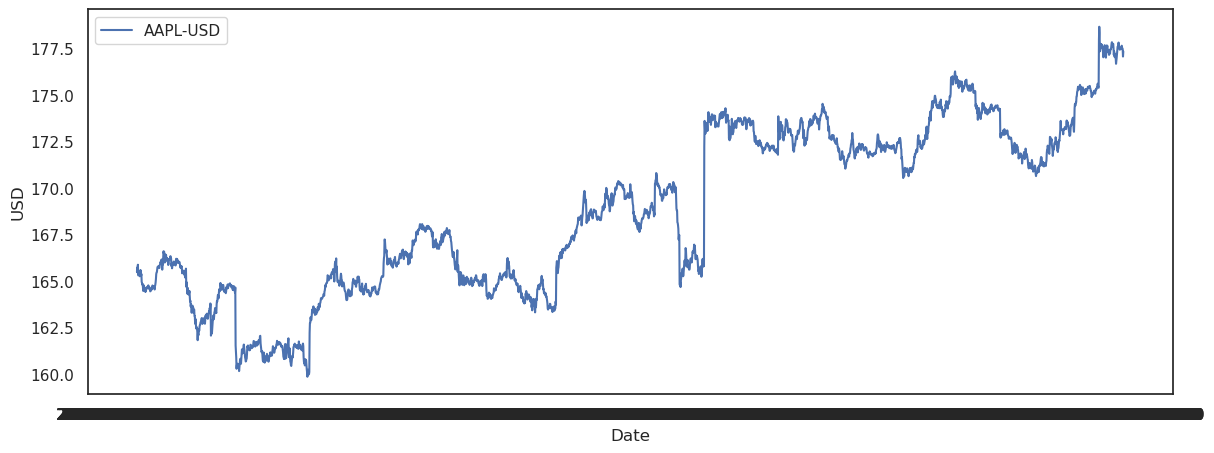

In [100]:
def plotDataset(data,x_label, y_label1,y_label2,y_name):
  plt.figure(figsize=(14, 5), dpi=100)
  plt.plot(data[x_label], data[y_label1], label='AAPL-USD')
  # plt.plot(data[x_label], y_label2, label=y_name)
  plt.xlabel('Date')
  plt.ylabel('USD')
  # plt.title('Figure 2: ETH-USDT price')
  plt.legend()
  plt.show()

output = dataset_ex_df
plotDataset(dataset_ex_df,"Datetime","Close",output,"SMA-9000")  

In [103]:
def plotSingleCol(data,lenth, y_label):
  plt.figure(figsize=(14, 5), dpi=100)
  plt.plot(np.arange(0, lenth),data, label=y_label)
  plt.xlabel('DateTime')
  plt.ylabel('USD')
  plt.title('Figure 2: AAPL-USDT price')
  plt.legend()
  plt.show()

#### NaN Checking Function

In [104]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

## Create Indicators

Simple Moving Average : 
*   SMA3 - 15m
*   SMA12 - 1h
*   SMA20 - 100m
*   SMA48 - 4h
*   SMA50 - 250m
*   SMA288 - 1d

Exponential Moving Average
*   EMA12 - 1h
*   EMA20 - 100m
*   EMA26 - 130m

Moving Average Convergence/Divergence
*   MACD12 - 1h
*   MACD24 - 2h

Relative Strength Index
*   RSI12 - 1h
*   RSI24 - 2h
*   RSI36 - 3h

Average True Range
*   ATR12 - 1h
*   ATR24 - 2h
*   ATR36 - 3h

Bollinger Bands
*   UpperBand12,LowerBand12  - 1h
*   UpperBand24,LowerBand24 - 2h
*   UpperBand36,LowerBand36 - 3h

MOM
*   MoM10

OBV
*   OBV

https://mrjbq7.github.io/ta-lib/

https://www.forex.in.rs/moving-average-for-5-min-chart/#:~:text=The%20best%20moving%20averages%20for,20%20MA%20and%2050%20MA.

In [105]:
def CreateInc(dataset,Close,High,Low):
  
  new_df = dataset.copy()

  # Moving Average
  new_df["SMA3"] = tb.SMA(dataset[Close],timeperiod=3)
  new_df["SMA12"] = tb.SMA(dataset[Close],timeperiod=12)
  new_df["SMA20"] = tb.SMA(dataset[Close],timeperiod=20)
  new_df["SMA48"] = tb.SMA(dataset[Close],timeperiod=48)
  new_df["SMA50"] = tb.SMA(dataset[Close],timeperiod=50)
  new_df["SMA288"] = tb.SMA(dataset[Close],timeperiod=288)
  m1 = max(new_df[new_df['SMA288'].isnull()].index)

  #Exponential Moving Average
  new_df["EMA12"] = tb.EMA(dataset[Close], timeperiod=12)
  new_df["EMA20"] = tb.EMA(dataset[Close], timeperiod=20)
  new_df["EMA26"] = tb.EMA(dataset[Close], timeperiod=26)
  m2 = max(new_df[new_df['EMA26'].isnull()].index)

  # Moving Avarage Convergence Divergernce
  MACD12, macdsignal12, macdhist12 = tb.MACD(dataset[Close], fastperiod=18, slowperiod=6, signalperiod=12)
  MACD24, macdsignal24, macdhist24 = tb.MACD(dataset[Close], fastperiod=36, slowperiod=12, signalperiod=24)
  new_df["MACD12"] = MACD12
  new_df["MACD24"] = MACD24
  m3 = max(new_df[new_df['MACD24'].isnull()].index)

  # Relative Strength Index
  new_df["RSI12"] = tb.RSI(dataset[Close], timeperiod=12)
  new_df["RSI24"] = tb.RSI(dataset[Close], timeperiod=24)
  new_df["RSI36"] = tb.RSI(dataset[Close], timeperiod=36)
  m4 = max(new_df[new_df['RSI36'].isnull()].index)

  # Average True Range
  new_df["ATR12"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=12)
  new_df["ATR24"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=24)
  new_df["ATR36"] = tb.ATR(dataset[High], dataset[Low], dataset[Close], timeperiod=36)
  m5 = max(new_df[new_df['ATR36'].isnull()].index)

  # Bolinger Bands
  upperband12, middleband12, lowerband12 = tb.BBANDS(dataset[Close], timeperiod=12, nbdevup=2, nbdevdn=2, matype=0)
  upperband24, middleband24, lowerband24 = tb.BBANDS(dataset[Close], timeperiod=24, nbdevup=2, nbdevdn=2, matype=0)
  upperband36, middleband36, lowerband36 = tb.BBANDS(dataset[Close], timeperiod=36, nbdevup=2, nbdevdn=2, matype=0)
  new_df["Upperband12"] = upperband12 ; new_df["Lowerband12"] = lowerband12
  new_df["Upperband24"] = upperband24 ; new_df["Lowerband24"] = lowerband24
  new_df["Upperband36"] = upperband36 ; new_df["Lowerband36"] = lowerband36
  m6 = max(new_df[new_df['Upperband36'].isnull()].index)

  # Momentum
  new_df["MOM10"] = tb.MOM(dataset[Close], timeperiod=10)
  m7 = max(new_df[new_df['MOM10'].isnull()].index)

  # Volume Indicators
  new_df["OBV"] = tb.OBV(dataset[Close], dataset["Volume"])
  # m8 = max(new_df[new_df["OBV"].isnull()].index)

  # Remove NaN values
  m = max(m1,m2,m3,m4,m5,m6,m7)
  new_df = new_df.loc[m+1:]

  return new_df


#### Get Full Dataset with indicators

In [106]:
dataset_Idc = CreateInc(dataset_ex_df,"Close","High","Low")
dataset_Idc = dataset_Idc.reset_index()
dataset_Idc = dataset_Idc.drop(columns=["index"])
dataset_Idc.head()

,Datetime,Open,High,Low,Volume,Close,pct_change,log_change,SMA3,SMA12,...,ATR24,ATR36,Upperband12,Lowerband12,Upperband24,Lowerband24,Upperband36,Lowerband36,MOM10,OBV
0,2023-04-06 17:55:00,164.698807,164.809998,164.615005,349318,164.809998,0.000729,0.000728,164.716665,164.526864,...,0.237188,0.250501,164.813808,164.239920,164.893358,164.296757,164.999388,163.937683,0.299896,17822698.0
1,2023-04-06 18:00:00,164.809998,164.869995,164.554993,421239,164.610001,-0.001214,-0.001214,164.703334,164.542698,...,0.240431,0.252293,164.825242,164.260154,164.855379,164.311402,164.964633,164.020771,0.200104,17401459.0
2,2023-04-06 18:05:00,164.604996,164.830002,164.600006,284448,164.750000,0.000850,0.000850,164.723333,164.562689,...,0.239996,0.251673,164.866339,164.259040,164.858120,164.310328,164.953370,164.078145,0.350006,17685907.0
3,2023-04-06 18:10:00,164.750000,164.839996,164.709900,218784,164.800003,0.000304,0.000303,164.720001,164.595198,...,0.235417,0.248296,164.909788,164.280609,164.873114,164.304501,164.933996,164.148075,0.400009,17904691.0
4,2023-04-06 18:15:00,164.797699,164.850006,164.679993,252622,164.779999,-0.000121,-0.000121,164.776667,164.626865,...,0.232692,0.246122,164.932868,164.320863,164.892230,164.304968,164.928765,164.192195,0.440002,17652069.0


In [107]:
dataset_Idc.isnull().sum()[dataset_Idc.isnull().sum()>0]

Series([], dtype: int64)

In [110]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['SMA20'],label='SMA 100m', color='g',linestyle='--')
    plt.plot(dataset['SMA50'],label='SMA 250m', color='r',linestyle='--')
    plt.plot(dataset['Upperband12'],label='Upper Band 1h', color='c')
    plt.plot(dataset['Lowerband12'],label='Lower Band 1h', color='c')
    plt.fill_between(x_, dataset['Lowerband12'], dataset['Upperband12'], alpha=0.15)
    plt.title('Technical indicators for  AAPL- last {} Time intervals.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD12')
    plt.plot(dataset['MACD12'],label='MACD 1h', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['MOM10'],label='Momentum 10', color='b',linestyle='-')

    plt.legend()
    plt.show()

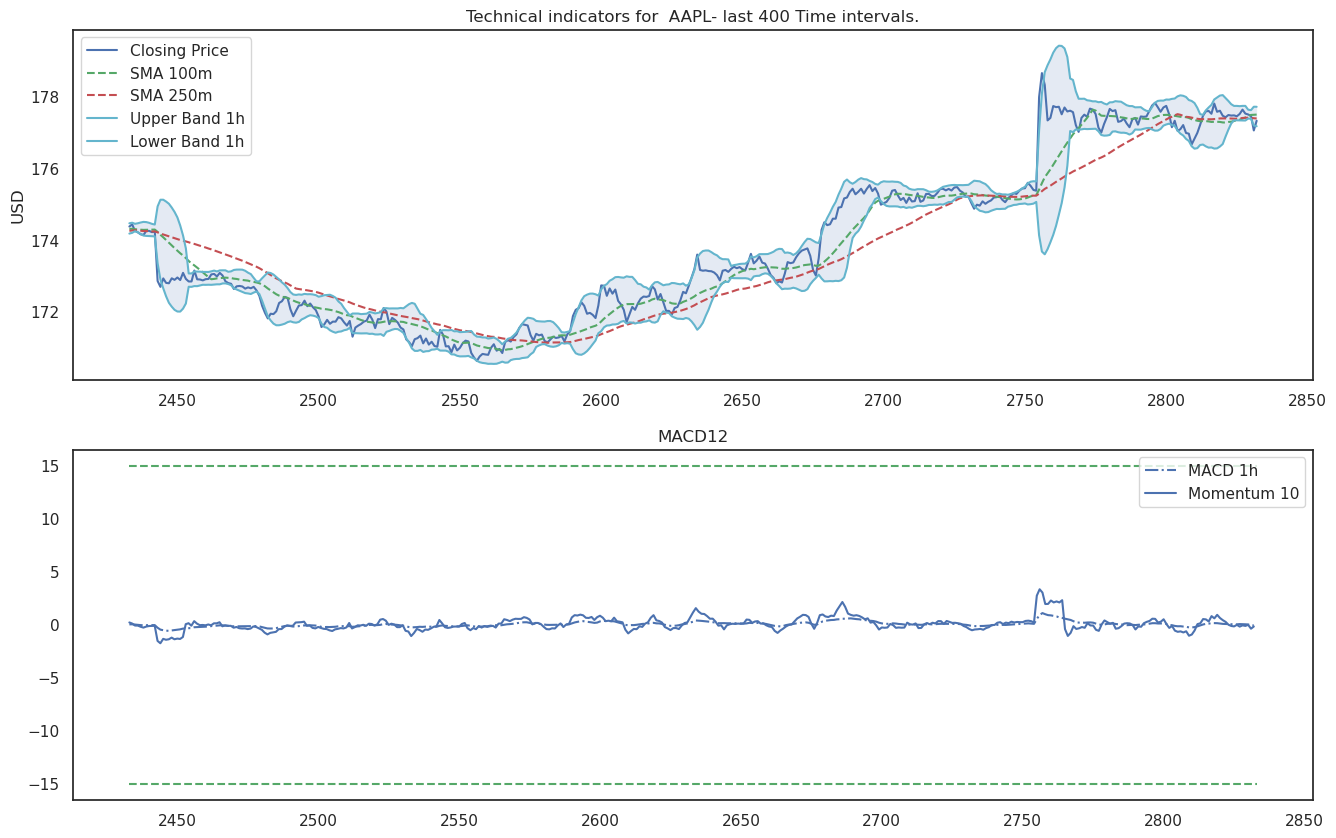

In [111]:
plot_technical_indicators(dataset_Idc,400)

In [112]:
dataset_Idc.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Volume', 'Close', 'pct_change',
       'log_change', 'SMA3', 'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288',
       'EMA12', 'EMA20', 'EMA26', 'MACD12', 'MACD24', 'RSI12', 'RSI24',
       'RSI36', 'ATR12', 'ATR24', 'ATR36', 'Upperband12', 'Lowerband12',
       'Upperband24', 'Lowerband24', 'Upperband36', 'Lowerband36', 'MOM10',
       'OBV'],
      dtype='object')

# Extract Multi frequency trends

#### Create Fourier Transformed values for Close price

In [113]:
close_fft = np.fft.fft(np.asarray(dataset_Idc['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
output_df_fft = fft_df.copy()

Do Inverse Fourier Transformation and extract Multi-Frequency trading patterns

/tmp/ipykernel_33/1982679581.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_33/1982679581.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_33/1982679581.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/_

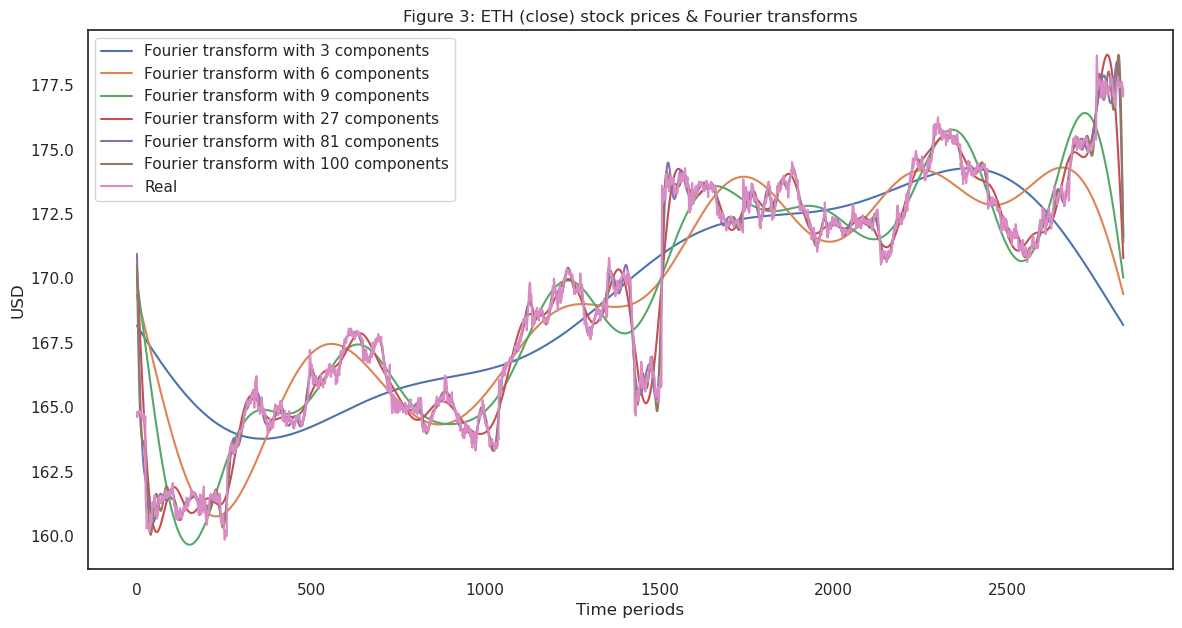

In [114]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 27, 81, 100]:
    fft_list_m10= np.copy(fft_list) 
    fft_list_m10[num_:-num_]=0
    output_df_fft[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10).astype('float')
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(dataset_Idc['Close'],  label='Real')
plt.xlabel('Time periods')
plt.ylabel('USD')
plt.title('Figure 3: ETH (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [115]:
output_df_fft.head()

,fft,absolute,angle,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,479379.389999+0.000000j,479379.389999,3.687748e-17,168.163255,169.332269,169.922092,170.484045,170.952676,170.521996
1,-963.237466+6708.238843j,6777.041743,1.713412e+00,168.141767,169.279294,169.820221,170.182180,170.290481,169.669014
2,-202.477597+1613.886755j,1626.538544,1.695604e+00,168.120295,169.226178,169.718069,169.879596,169.634480,168.847679
3,-641.458159+2528.965372j,2609.048567,1.819202e+00,168.098840,169.172925,169.615652,169.576663,168.990114,168.069982
4,77.537123+1896.721581j,1898.305761,1.529940e+00,168.077402,169.119538,169.512988,169.273747,168.362492,167.346261


In [116]:
output_df_fft.shape

(2833, 9)

#### Merge Fourier transformed values & full dataset

In [117]:
df_idc_fft = pd.concat([dataset_Idc,output_df_fft[["FT_3components",	"FT_6components",	"FT_9components",	"FT_27components",	"FT_81components",	"FT_100components"]]], axis=1)
df_idc_fft

,Datetime,Open,High,Low,Volume,Close,pct_change,log_change,SMA3,SMA12,...,Upperband36,Lowerband36,MOM10,OBV,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
0,2023-04-06 17:55:00,164.698807,164.809998,164.615005,349318,164.809998,0.000729,0.000728,164.716665,164.526864,...,164.999388,163.937683,0.299896,17822698.0,168.163255,169.332269,169.922092,170.484045,170.952676,170.521996
1,2023-04-06 18:00:00,164.809998,164.869995,164.554993,421239,164.610001,-0.001214,-0.001214,164.703334,164.542698,...,164.964633,164.020771,0.200104,17401459.0,168.141767,169.279294,169.820221,170.182180,170.290481,169.669014
2,2023-04-06 18:05:00,164.604996,164.830002,164.600006,284448,164.750000,0.000850,0.000850,164.723333,164.562689,...,164.953370,164.078145,0.350006,17685907.0,168.120295,169.226178,169.718069,169.879596,169.634480,168.847679
3,2023-04-06 18:10:00,164.750000,164.839996,164.709900,218784,164.800003,0.000304,0.000303,164.720001,164.595198,...,164.933996,164.148075,0.400009,17904691.0,168.098840,169.172925,169.615652,169.576663,168.990114,168.069982
4,2023-04-06 18:15:00,164.797699,164.850006,164.679993,252622,164.779999,-0.000121,-0.000121,164.776667,164.626865,...,164.928765,164.192195,0.440002,17652069.0,168.077402,169.119538,169.512988,169.273747,168.362492,167.346261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,2023-05-30 19:35:00,177.639999,177.669907,177.479996,322957,177.529999,-0.000619,-0.000619,177.563334,177.540592,...,177.984772,176.852179,-0.050003,102623390.0,168.270932,169.594900,170.426631,171.969807,174.155764,174.775622
2829,2023-05-30 19:40:00,177.520004,177.610001,177.360001,503320,177.505005,-0.000141,-0.000141,177.558334,177.515176,...,177.986929,176.853079,-0.104996,102120070.0,168.249367,169.542685,170.326421,171.677003,173.548638,173.974329
2830,2023-05-30 19:45:00,177.500000,177.669998,177.375000,524431,177.464996,-0.000225,-0.000225,177.500000,177.505592,...,177.980144,176.852363,-0.005005,101595639.0,168.227816,169.490311,170.225845,171.381666,172.919148,173.134075
2831,2023-05-30 19:50:00,177.464996,177.479996,177.039993,1019115,177.059998,-0.002282,-0.002285,177.343333,177.459759,...,177.960715,176.833181,-0.367096,100576524.0,168.206280,169.437781,170.124921,171.084153,172.272822,172.268898


In [118]:
df_idc_fft.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Volume', 'Close', 'pct_change',
       'log_change', 'SMA3', 'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288',
       'EMA12', 'EMA20', 'EMA26', 'MACD12', 'MACD24', 'RSI12', 'RSI24',
       'RSI36', 'ATR12', 'ATR24', 'ATR36', 'Upperband12', 'Lowerband12',
       'Upperband24', 'Lowerband24', 'Upperband36', 'Lowerband36', 'MOM10',
       'OBV', 'FT_3components', 'FT_6components', 'FT_9components',
       'FT_27components', 'FT_81components', 'FT_100components'],
      dtype='object')

# Build ARIMA Model

In [31]:
# series = data_FT['Close']
# model = ARIMA(series, order=(5, 1, 0))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())

In [32]:
# len(series) * 0.002

In [33]:
# pd.plotting.autocorrelation_plot(series)
# plt.figure(figsize=(10, 7), dpi=80)
# plt.show() 

In [34]:
# X = series.values
# size = int(len(X) * 0.998)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)

In [35]:
# error = math.sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % error)

In [36]:
# # Plot the predicted (from ARIMA) and real prices

# plt.figure(figsize=(12, 6), dpi=100)
# plt.plot(test, label='Real')
# plt.plot(predictions, color='red', label='Predicted')
# plt.xlabel('Time Periods')
# plt.ylabel('USD')
# plt.title('Figure 5: ARIMA model on BTC Closing price')
# plt.legend()
# plt.show()

# Create new features with VAE

In [119]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

#### Create dataset :  train_x, train_y, test_x, test_y

In [120]:
data = df_idc_fft.iloc[:,1:]
data.shape

(2833, 38)

In [121]:
features = data.shape[1]

In [122]:
data['y'] = data['Close']

x = data.iloc[:, :features].values
y = data.iloc[:, features].values

split = int(data.shape[0]* 0.5)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1416, 38) trainY: (1416,)
testX: (1417, 38) testY: (1417,)


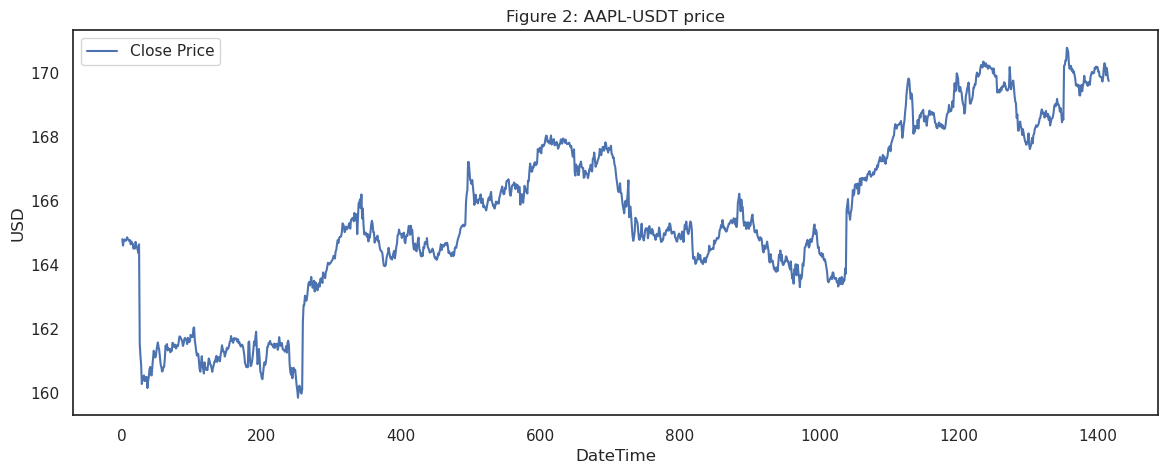

In [123]:
plotSingleCol(train_y,len(train_y),"Close Price")

#### MinMax Scalling

In [124]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))


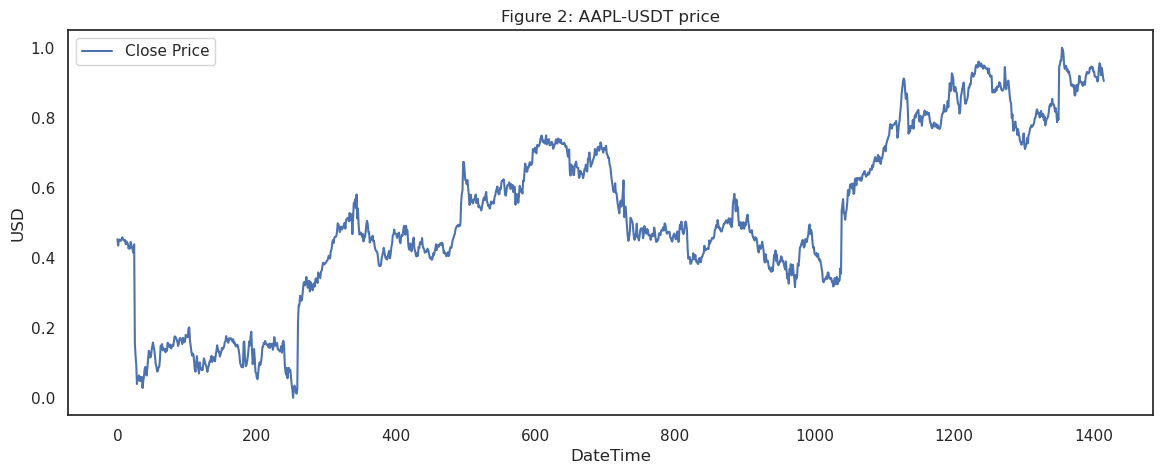

In [125]:
plotSingleCol(train_y,len(train_y),"Close Price")

In [126]:
train_x.shape

(1416, 38)

#### Implement Variational AutoEncorder

In [133]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

#### Create dataset for VAE

In [134]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# Create dataset = (53,128,41) : num of batches, batch size, features
# 53 = 6700/128 
model = VAE([features, 400, 400, 400, 10], 10)

#### Train the model

[1/200] Loss: 281.81061267852783
[2/200] Loss: 258.0446603298187
[3/200] Loss: 237.48973679542542
[4/200] Loss: 222.5645785331726
[5/200] Loss: 218.87082982063293
[6/200] Loss: 230.5713987350464
[7/200] Loss: 240.98734426498413
[8/200] Loss: 231.17069339752197
[9/200] Loss: 212.78196477890015
[10/200] Loss: 203.53699135780334
[11/200] Loss: 205.02978205680847
[12/200] Loss: 210.84987604618073
[13/200] Loss: 215.76528882980347
[14/200] Loss: 217.53225207328796
[15/200] Loss: 215.69146037101746
[16/200] Loss: 210.7734044790268
[17/200] Loss: 203.83787631988525
[18/200] Loss: 196.27522599697113
[19/200] Loss: 189.46966457366943
[20/200] Loss: 185.08418011665344
[21/200] Loss: 184.61207127571106
[22/200] Loss: 188.2144627571106
[23/200] Loss: 193.05780625343323
[24/200] Loss: 194.04997634887695
[25/200] Loss: 188.9061620235443
[26/200] Loss: 180.7879765033722
[27/200] Loss: 174.35702073574066
[28/200] Loss: 171.55816388130188
[29/200] Loss: 171.66507029533386
[30/200] Loss: 173.06546068191

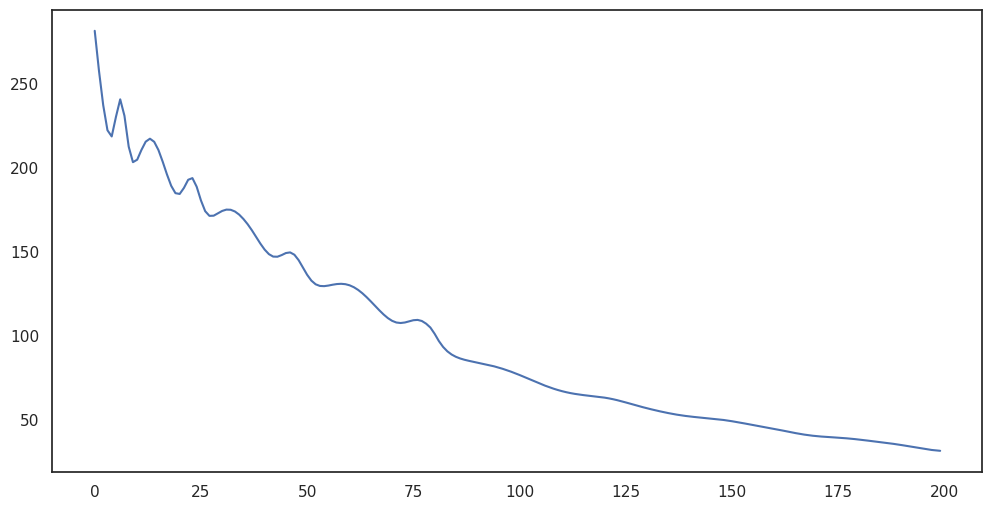

In [135]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")


num_epochs = 200
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

#### Take output

In [136]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))
print(train_x_mu.shape)
print(test_x_mu.shape)

torch.Size([1416, 10])
torch.Size([1417, 10])


In [137]:
df_tr = pd.DataFrame(VAE_train_x.detach().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts = pd.DataFrame(VAE_test_x.detach().numpy(), columns=['enc1', 'enc2', 'enc3','enc4', 'enc5', 'enc6','enc7', 'enc8', 'enc9','enc10'])
df_ts.index += 1416

In [138]:
df_vae = pd.concat([df_tr, df_ts], axis=0)
df_vae

,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,0.228494,-0.539834,0.244125,-2.324714,-1.291089,-0.439414,-0.749114,0.257136,0.939366,2.218632
1,-0.759821,-0.330965,-0.342259,0.519918,-1.078405,1.767244,0.840164,-0.860659,-1.822484,1.002612
2,1.169097,1.537228,2.215817,0.048950,0.543840,-0.967094,-0.537568,-0.487846,-0.664040,-1.424083
3,-0.628935,0.342847,0.570084,1.756920,1.104039,0.347172,0.370260,-0.050243,2.063815,-0.419387
4,-0.274828,-1.368572,-0.542938,0.092364,0.223433,-1.120603,-1.023976,0.299940,-0.513609,-1.156895
...,...,...,...,...,...,...,...,...,...,...
2828,-0.440862,0.607103,-0.603653,0.252790,0.200958,-1.805585,0.205365,-2.232817,-1.206809,0.488570
2829,-0.101430,0.232541,-1.011397,0.382027,-0.535479,-0.054649,-0.252986,-0.334236,1.003822,0.058204
2830,0.306909,1.804652,1.048202,-0.138216,-0.773884,-0.719856,0.066745,0.113160,-2.273516,0.454727
2831,-1.296681,-1.543581,1.843917,-0.849581,-1.959773,1.732379,-2.097516,-0.241379,-0.270285,-0.979257


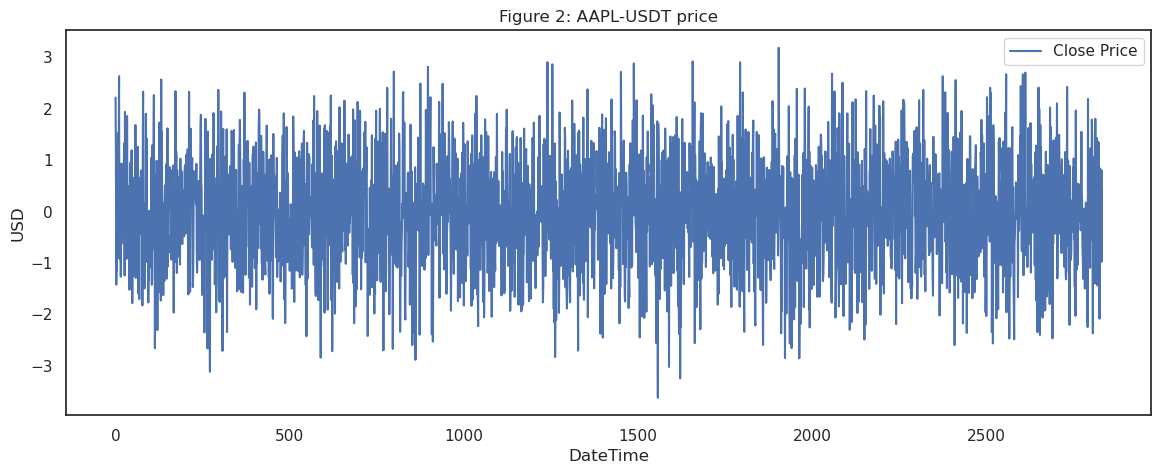

In [139]:
plotSingleCol(df_vae["enc10"],df_vae.shape[0],"Close Price")

In [140]:
df_idc_fft_vae = pd.concat([df_idc_fft, df_vae], axis=1)
df_idc_fft_vae.head()

,Datetime,Open,High,Low,Volume,Close,pct_change,log_change,SMA3,SMA12,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2023-04-06 17:55:00,164.698807,164.809998,164.615005,349318,164.809998,0.000729,0.000728,164.716665,164.526864,...,0.228494,-0.539834,0.244125,-2.324714,-1.291089,-0.439414,-0.749114,0.257136,0.939366,2.218632
1,2023-04-06 18:00:00,164.809998,164.869995,164.554993,421239,164.610001,-0.001214,-0.001214,164.703334,164.542698,...,-0.759821,-0.330965,-0.342259,0.519918,-1.078405,1.767244,0.840164,-0.860659,-1.822484,1.002612
2,2023-04-06 18:05:00,164.604996,164.830002,164.600006,284448,164.750000,0.000850,0.000850,164.723333,164.562689,...,1.169097,1.537228,2.215817,0.048950,0.543840,-0.967094,-0.537568,-0.487846,-0.664040,-1.424083
3,2023-04-06 18:10:00,164.750000,164.839996,164.709900,218784,164.800003,0.000304,0.000303,164.720001,164.595198,...,-0.628935,0.342847,0.570084,1.756920,1.104039,0.347172,0.370260,-0.050243,2.063815,-0.419387
4,2023-04-06 18:15:00,164.797699,164.850006,164.679993,252622,164.779999,-0.000121,-0.000121,164.776667,164.626865,...,-0.274828,-1.368572,-0.542938,0.092364,0.223433,-1.120603,-1.023976,0.299940,-0.513609,-1.156895


In [141]:
df_idc_fft_vae.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Volume', 'Close', 'pct_change',
       'log_change', 'SMA3', 'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288',
       'EMA12', 'EMA20', 'EMA26', 'MACD12', 'MACD24', 'RSI12', 'RSI24',
       'RSI36', 'ATR12', 'ATR24', 'ATR36', 'Upperband12', 'Lowerband12',
       'Upperband24', 'Lowerband24', 'Upperband36', 'Lowerband36', 'MOM10',
       'OBV', 'FT_3components', 'FT_6components', 'FT_9components',
       'FT_27components', 'FT_81components', 'FT_100components', 'enc1',
       'enc2', 'enc3', 'enc4', 'enc5', 'enc6', 'enc7', 'enc8', 'enc9',
       'enc10'],
      dtype='object')

In [142]:
NaNCheck(df_idc_fft_vae)

Series([], dtype: int64)

Save Processed dataframe with all added features

In [143]:
df_idc_fft_vae.to_csv("aapl_df_idc_fft_vae.csv", index=False)

# PCA

In [144]:
df_pca=pd.read_csv("aapl_df_idc_fft_vae.csv")
df_pca

,Datetime,Open,High,Low,Volume,Close,pct_change,log_change,SMA3,SMA12,...,enc1,enc2,enc3,enc4,enc5,enc6,enc7,enc8,enc9,enc10
0,2023-04-06 17:55:00,164.698807,164.809998,164.615005,349318,164.809998,0.000729,0.000728,164.716665,164.526864,...,0.228494,-0.539834,0.244125,-2.324714,-1.291089,-0.439414,-0.749114,0.257136,0.939366,2.218633
1,2023-04-06 18:00:00,164.809998,164.869995,164.554993,421239,164.610001,-0.001214,-0.001214,164.703334,164.542698,...,-0.759821,-0.330965,-0.342259,0.519918,-1.078405,1.767244,0.840164,-0.860660,-1.822484,1.002612
2,2023-04-06 18:05:00,164.604996,164.830002,164.600006,284448,164.750000,0.000850,0.000850,164.723333,164.562689,...,1.169097,1.537228,2.215817,0.048950,0.543840,-0.967094,-0.537568,-0.487846,-0.664040,-1.424083
3,2023-04-06 18:10:00,164.750000,164.839996,164.709900,218784,164.800003,0.000304,0.000303,164.720001,164.595198,...,-0.628935,0.342847,0.570084,1.756919,1.104039,0.347172,0.370260,-0.050243,2.063815,-0.419387
4,2023-04-06 18:15:00,164.797699,164.850006,164.679993,252622,164.779999,-0.000121,-0.000121,164.776667,164.626865,...,-0.274828,-1.368572,-0.542938,0.092364,0.223433,-1.120603,-1.023976,0.299940,-0.513609,-1.156895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,2023-05-30 19:35:00,177.639999,177.669907,177.479996,322957,177.529999,-0.000619,-0.000619,177.563334,177.540592,...,-0.440862,0.607103,-0.603653,0.252790,0.200958,-1.805585,0.205365,-2.232817,-1.206809,0.488570
2829,2023-05-30 19:40:00,177.520004,177.610001,177.360001,503320,177.505005,-0.000141,-0.000141,177.558334,177.515176,...,-0.101430,0.232541,-1.011397,0.382027,-0.535479,-0.054649,-0.252986,-0.334236,1.003822,0.058204
2830,2023-05-30 19:45:00,177.500000,177.669998,177.375000,524431,177.464996,-0.000225,-0.000225,177.500000,177.505592,...,0.306909,1.804652,1.048202,-0.138216,-0.773884,-0.719856,0.066745,0.113160,-2.273516,0.454727
2831,2023-05-30 19:50:00,177.464996,177.479996,177.039993,1019115,177.059998,-0.002282,-0.002285,177.343333,177.459759,...,-1.296681,-1.543581,1.843917,-0.849581,-1.959773,1.732379,-2.097516,-0.241379,-0.270285,-0.979257


In [145]:
df_pca=df_pca.drop(['Datetime'], axis=1)

In [146]:
df_pca.columns

Index(['Open', 'High', 'Low', 'Volume', 'Close', 'pct_change', 'log_change',
       'SMA3', 'SMA12', 'SMA20', 'SMA48', 'SMA50', 'SMA288', 'EMA12', 'EMA20',
       'EMA26', 'MACD12', 'MACD24', 'RSI12', 'RSI24', 'RSI36', 'ATR12',
       'ATR24', 'ATR36', 'Upperband12', 'Lowerband12', 'Upperband24',
       'Lowerband24', 'Upperband36', 'Lowerband36', 'MOM10', 'OBV',
       'FT_3components', 'FT_6components', 'FT_9components', 'FT_27components',
       'FT_81components', 'FT_100components', 'enc1', 'enc2', 'enc3', 'enc4',
       'enc5', 'enc6', 'enc7', 'enc8', 'enc9', 'enc10'],
      dtype='object')

In [147]:
NaNCheck(df_pca)

Series([], dtype: int64)

Standardizing the data

In [148]:
X = df_pca.values # matrix of dataframe 
sc = StandardScaler() 
X_std = sc.fit_transform(X) # standardizing the data

### Apply PCA

In [149]:
pca = PCA()
X_pca = pca.fit_transform(X_std) # fit and reduce dimensions
print(pca.n_components_)

48


Determine the number of components

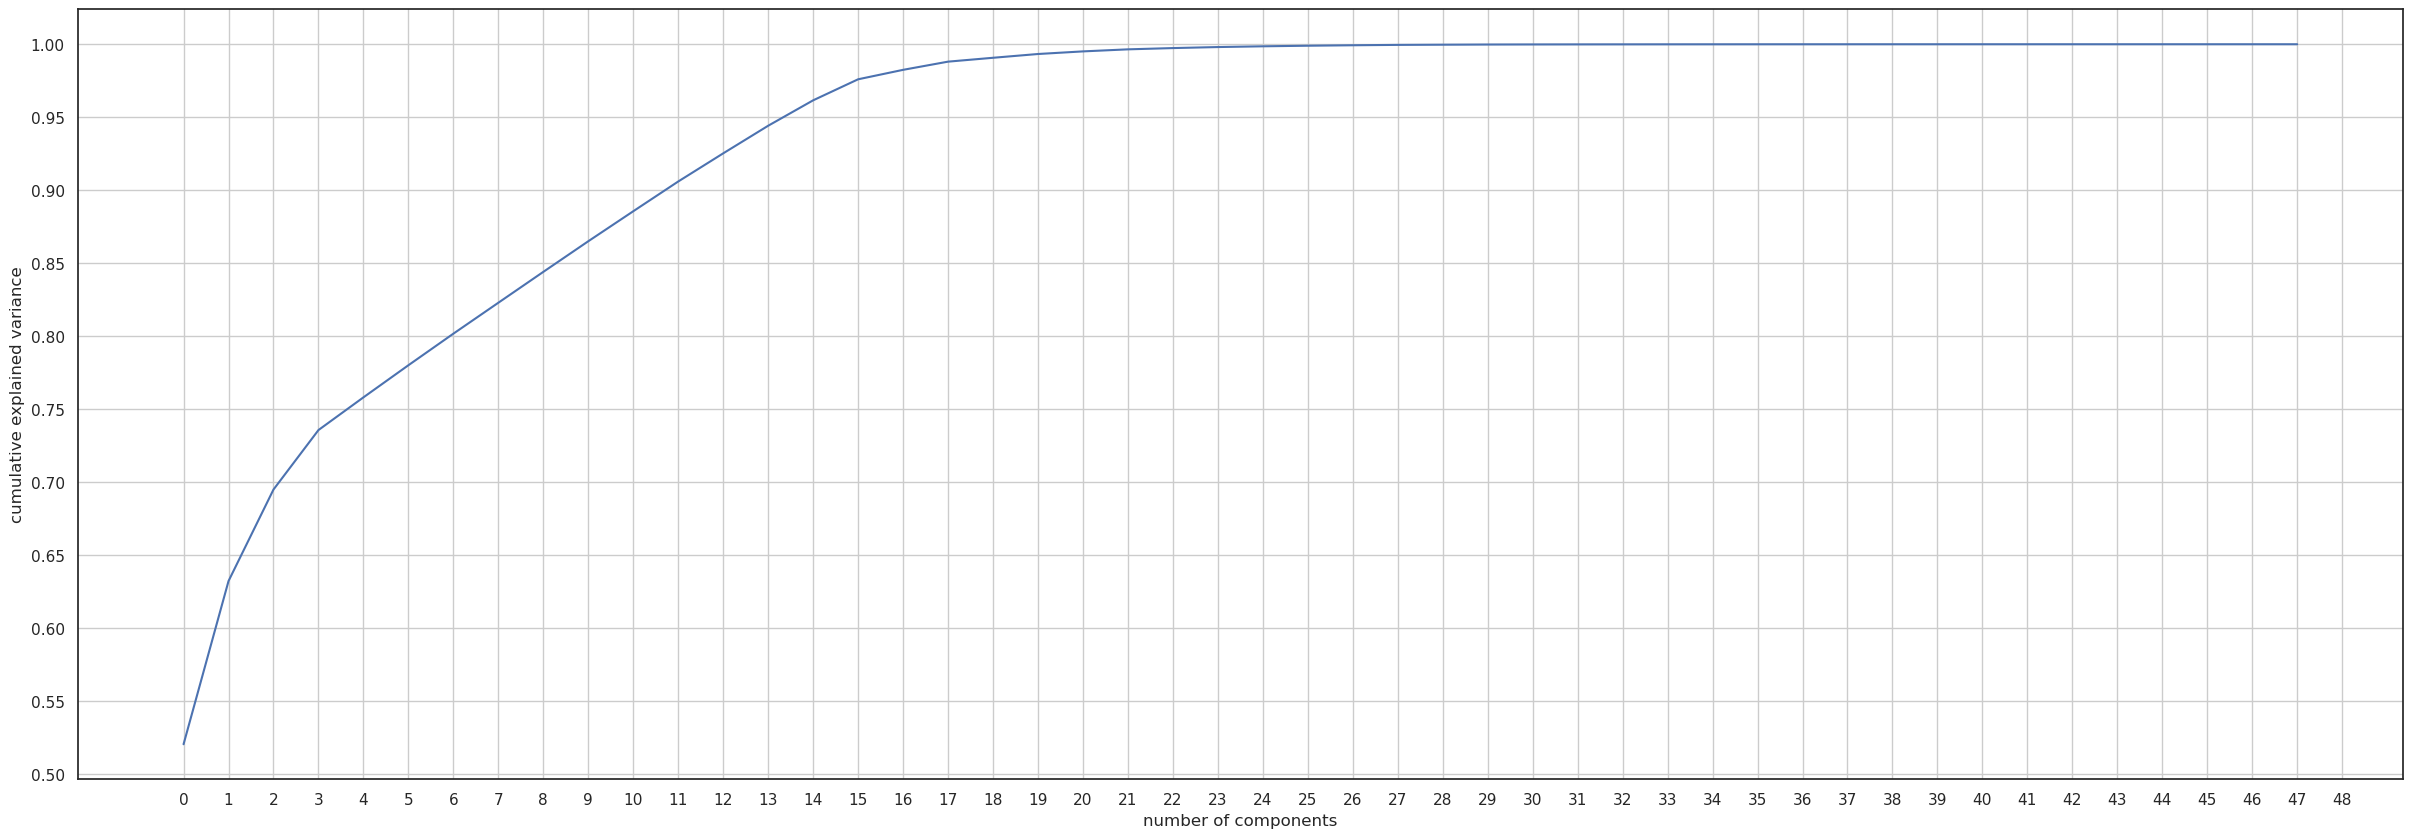

In [150]:
plt.figure(figsize=(30, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, df_pca.shape[1]+1, 1.0))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.show()

Dimensionality Reduction

Select *num_components = 21*

In [151]:
num_components = 21
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

In [152]:
print(df_pca.shape)
print(X_pca.shape)

(2833, 48)
(2833, 21)


Finding the most important features set

In [153]:
n_pcs= pca.n_components_ # get number of component

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_pca.columns

# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
for i in most_important_names:
  print(i,end="\n")

EMA12
RSI24
ATR24
pct_change
enc7
enc1
enc2
enc5
enc6
enc8
enc4
enc9
enc7
enc8
Volume
MOM10
FT_3components
MACD24
FT_9components
ATR12
OBV


In [154]:
df_PCA=X_pca.copy()
df_PCA = pd.DataFrame(df_PCA,columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10","pca11","pca12","pca13","pca14","pca15","pca16","pca17","pca18","pca19","pca20","pca21"])

In [155]:
df_PCA.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21
0,3.861889,1.647604,-1.259875,0.224710,0.071460,0.534932,-1.436081,-2.766425,0.105815,0.952818,...,1.379835,-0.276658,0.226766,-0.182107,0.382202,-1.088653,-0.156739,-1.133729,-0.541921,0.437902
1,3.952484,0.529667,-0.976079,-1.490865,0.803715,1.389456,0.037335,-0.696835,1.327695,-0.996293,...,-2.143748,-0.777670,-0.464317,0.408051,0.104638,-0.939459,-0.087803,-1.218121,-0.540939,0.525441
2,4.049863,1.369663,-1.197805,0.612041,-0.099139,0.461366,2.536005,0.232977,-1.430041,-0.043162,...,0.781357,0.600255,-0.045413,-0.812617,0.411642,-1.050052,0.061561,-1.116354,-0.636433,0.526208
3,4.106028,1.355737,-1.382674,-0.114705,0.619365,-1.008645,-0.166459,1.656699,1.393464,-0.799754,...,1.174868,0.405368,0.414153,-0.569050,0.418681,-0.921155,-0.163584,-1.117111,-0.562105,0.474217
4,4.165689,1.202872,-1.381348,-0.337285,-1.152584,-0.124953,-1.078002,0.386901,-1.247837,0.082958,...,-0.955234,0.889601,0.524815,-0.269641,0.560328,-0.879234,-0.195417,-1.099572,-0.525607,0.468941


# Feature Selection

In [157]:
df=df_PCA.copy()
df["Close"] = df_pca["Close"]
df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,3.861889,1.647604,-1.259875,0.224710,0.071460,0.534932,-1.436081,-2.766425,0.105815,0.952818,...,-0.276658,0.226766,-0.182107,0.382202,-1.088653,-0.156739,-1.133729,-0.541921,0.437902,164.809998
1,3.952484,0.529667,-0.976079,-1.490865,0.803715,1.389456,0.037335,-0.696835,1.327695,-0.996293,...,-0.777670,-0.464317,0.408051,0.104638,-0.939459,-0.087803,-1.218121,-0.540939,0.525441,164.610001
2,4.049863,1.369663,-1.197805,0.612041,-0.099139,0.461366,2.536005,0.232977,-1.430041,-0.043162,...,0.600255,-0.045413,-0.812617,0.411642,-1.050052,0.061561,-1.116354,-0.636433,0.526208,164.750000
3,4.106028,1.355737,-1.382674,-0.114705,0.619365,-1.008645,-0.166459,1.656699,1.393464,-0.799754,...,0.405368,0.414153,-0.569050,0.418681,-0.921155,-0.163584,-1.117111,-0.562105,0.474217,164.800003
4,4.165689,1.202872,-1.381348,-0.337285,-1.152584,-0.124953,-1.078002,0.386901,-1.247837,0.082958,...,0.889601,0.524815,-0.269641,0.560328,-0.879234,-0.195417,-1.099572,-0.525607,0.468941,164.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,-7.957424,-0.148817,-0.636897,-0.716527,-2.035540,0.567473,1.010604,0.184765,-0.354598,-0.121579,...,-2.214568,1.146006,-0.388858,-0.806968,1.799823,-0.378627,1.293263,1.044089,-0.344348,177.529999
2829,-7.870366,-0.136655,-0.525096,-0.383512,-0.915798,-0.494582,-0.622464,0.088387,0.559699,-0.459848,...,-0.316007,-0.302916,-0.107670,-1.340004,1.810827,-0.257189,1.269024,1.094499,-0.359197,177.505005
2830,-7.784696,-0.280590,-0.399723,-0.204544,-0.149761,0.691154,2.099791,-0.984369,-0.730041,0.903584,...,-1.204233,-0.856892,-0.491261,-1.079945,1.805723,-0.190964,1.283718,1.040516,-0.329226,177.464996
2831,-7.619150,-1.788985,0.306465,-2.153457,0.401707,0.401881,0.106664,-2.314762,0.315999,-0.730313,...,3.083596,1.159306,0.529858,-1.545388,2.077079,0.087230,1.119815,1.118155,-0.270999,177.059998


In [158]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [159]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 2833 samples, and 22 features.


In [160]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

### XGBOOST

In [165]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.drop(columns=["Close"])
    
    train_samples = int(X.shape[0] * 0.5)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [166]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df)

In [167]:
X_train_FI.columns

Index(['pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9',
       'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17',
       'pca18', 'pca19', 'pca20', 'pca21'],
      dtype='object')

In [168]:
print("Shape of x_train : ",X_train_FI.shape[0],",", X_train_FI.shape[1])
print("Shape of x_test : ",X_test_FI.shape[0],",", X_test_FI.shape[1])

Shape of x_train :  1416 , 21
Shape of x_test :  1417 , 21


In [169]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [170]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [171]:
eval_result = regressor.evals_result()
eval_result

{'validation_0': OrderedDict([('rmse',
               [156.6046895771616,
                148.7823318786634,
                141.3509368799019,
                134.2909854142019,
                127.58391653445365,
                121.21210433749026,
                115.15881303311919,
                109.40813196855113,
                103.94494394106756,
                98.75491013725961,
                93.82437870545833,
                89.14039240067792,
                84.6906424626945,
                80.46344627074339,
                76.44751005416632,
                72.63216213076737,
                69.0073807199336,
                65.5635422424591,
                62.291710434635114,
                59.18322345414086,
                56.22995621538899,
                53.42413579707062,
                50.758449979213815,
                48.22580625363619,
                45.8196875467249,
                43.53369072094223,
                41.361807129161406,
            

In [172]:
training_rounds = range(len(eval_result['validation_0']['rmse']))
training_rounds

range(0, 150)

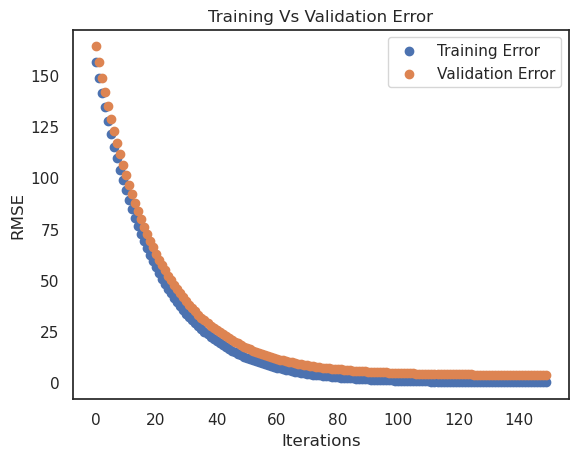

In [173]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#### Check Feature importance

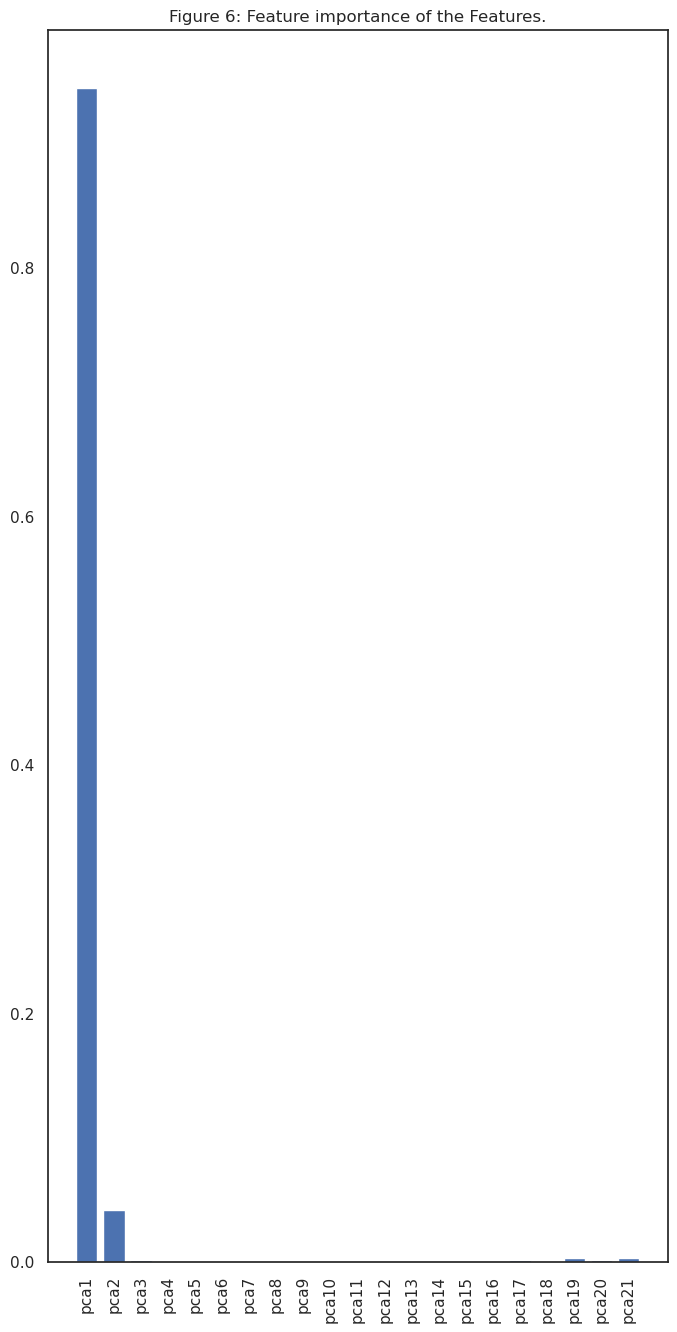

In [174]:
fig = plt.figure(figsize=(8,16))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the Features.')
plt.show()

weight: The number of times a feature is used to split the data across all trees.

gain: The average gain of the feature when it is used in a tree.

cover: The average coverage of the feature when it is used in a tree (coverage is defined as the number of samples affected by the split).

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

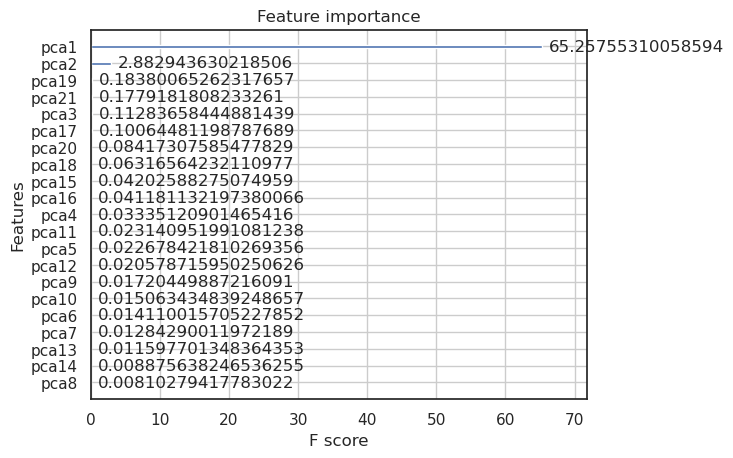

In [175]:
xgb.plot_importance(xgbModel, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

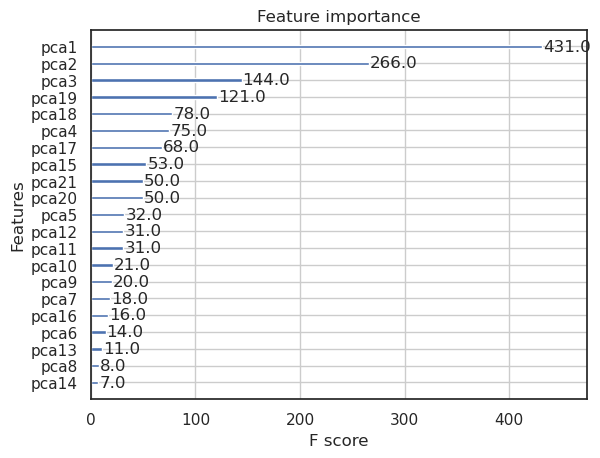

In [176]:
xgb.plot_importance(xgbModel, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

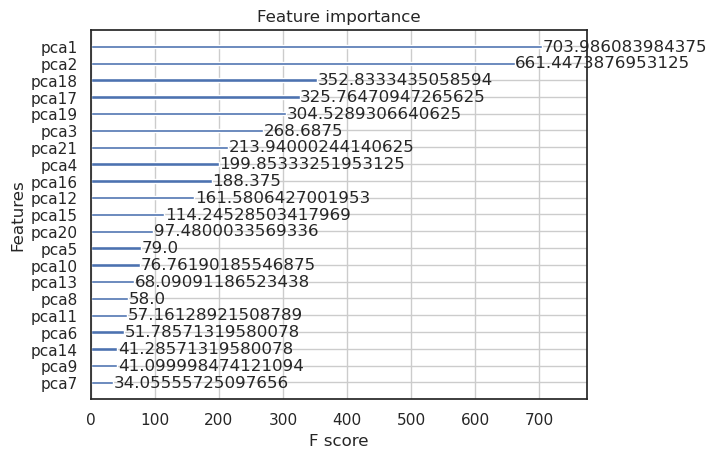

In [177]:
xgb.plot_importance(xgbModel, importance_type='cover')

In [178]:
df = df.drop(columns=["pca14"])

In [179]:
df.shape

(2833, 21)

### MI-Score

In [180]:
# labels_df = labels_df.iloc[:20000].values.reshape((20000,1))
# features_df = features_df.iloc[:20000]

In [87]:
# features_df

In [88]:
# features_df.shape

In [89]:
# labels_df.shape

In [90]:
# def make_mi_scores(X, y, discrete_features):
#     mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
#     mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
#     mi_scores = mi_scores.sort_values(ascending=False)
#     return mi_scores


# discrete_features=features_df.dtypes == float
# mi_scores = make_mi_scores(features_df,labels_df,discrete_features)

# def plot_mi_scores(scores):
#     scores = scores.sort_values(ascending=True)
#     width = np.arange(len(scores))
#     ticks = list(scores.index)
#     plt.barh(width, scores)
#     plt.yticks(width, ticks)
#     plt.title("Mutual Information Scores")


# plt.figure(dpi=100, figsize=(8, 5))
# plot_mi_scores(mi_scores)

### Identifying Feature Correlation 

<Axes: >

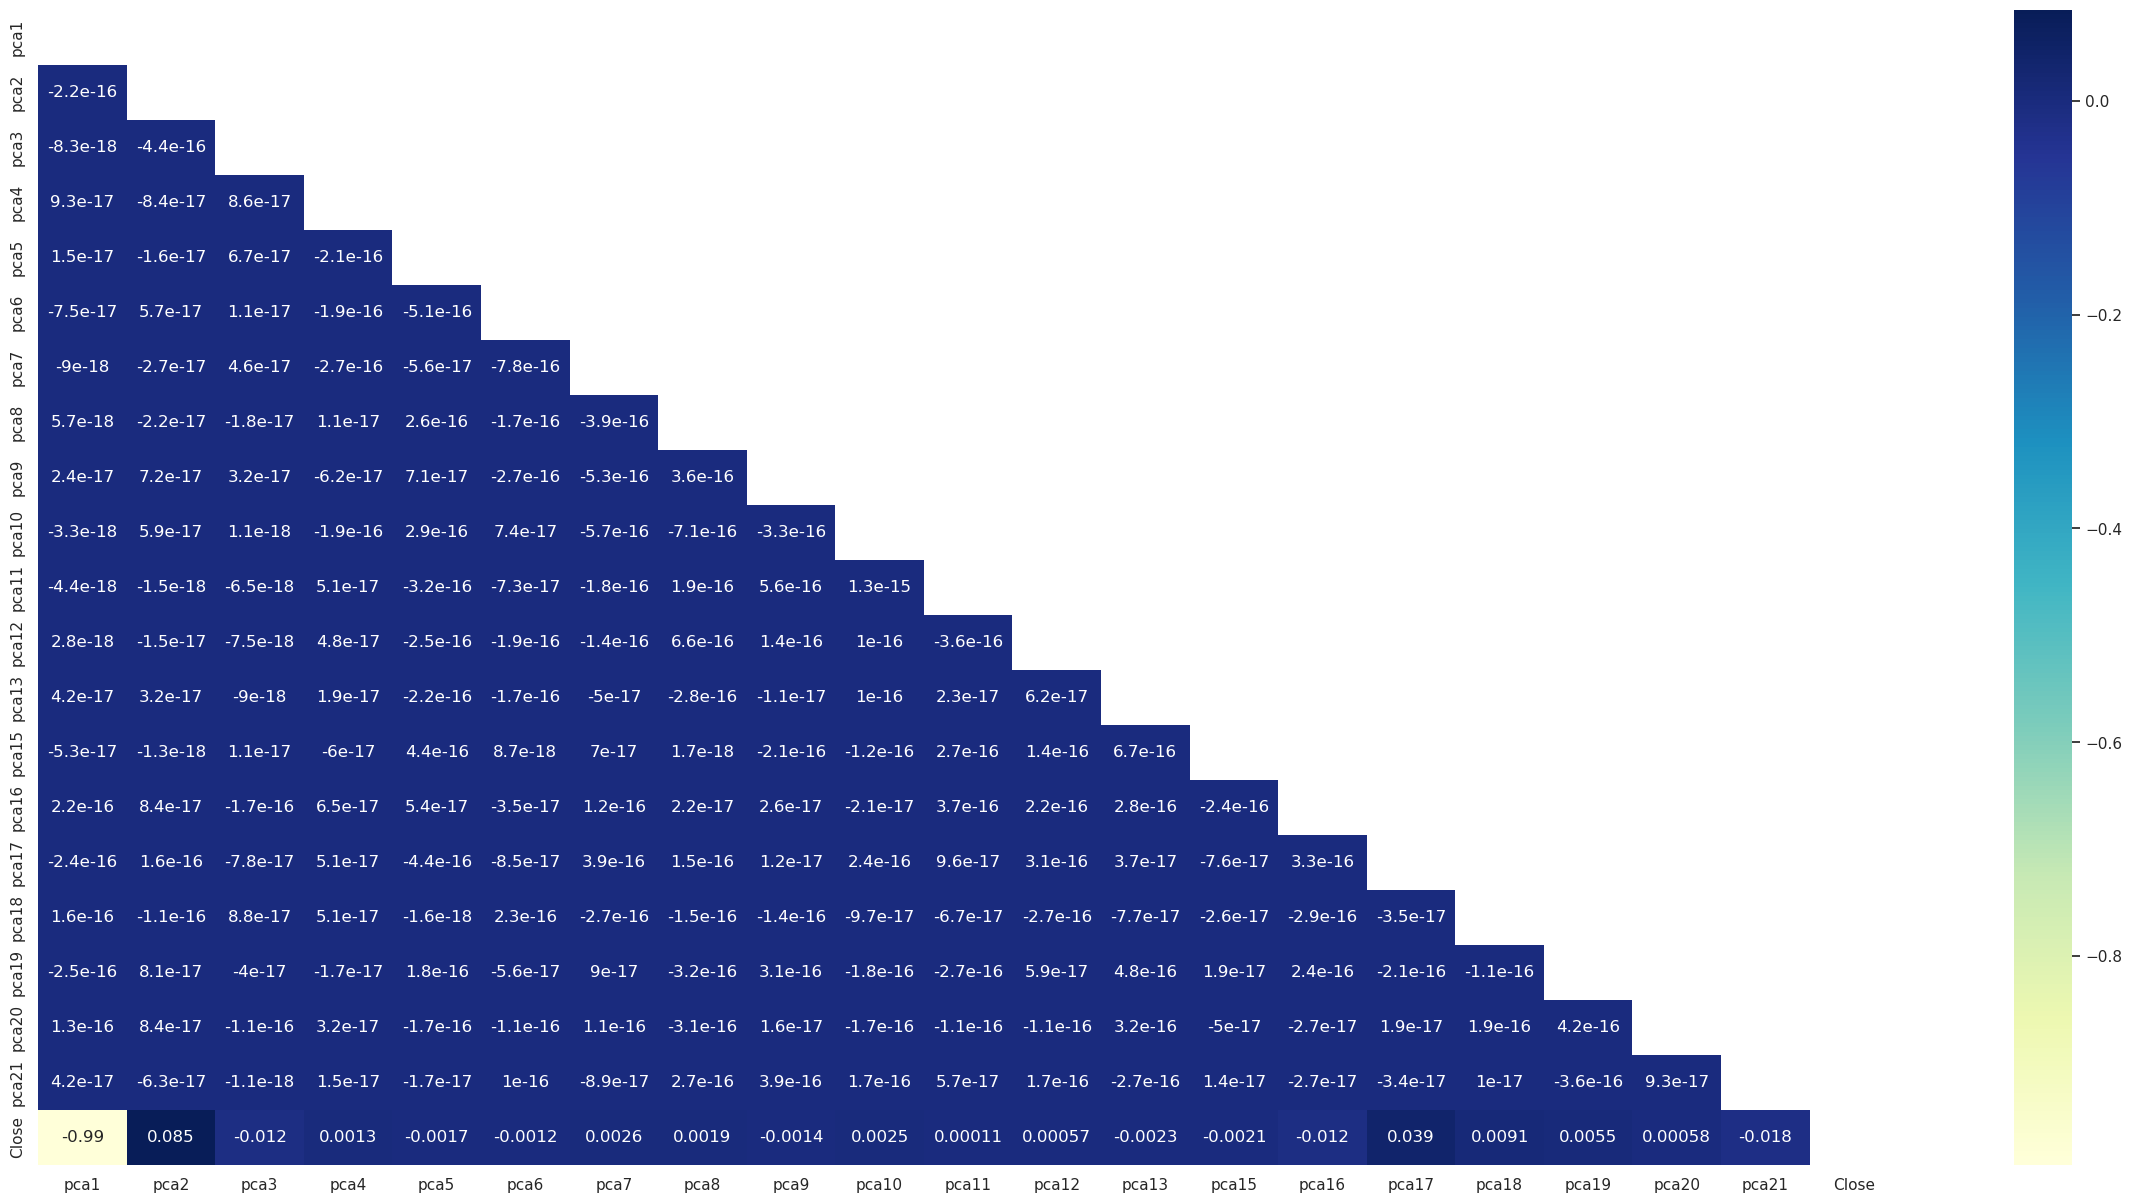

In [181]:
corr= df.corr()
matrix = np.triu(corr)

plt.figure(figsize=[30,15])
sns.heatmap(corr, annot=True, mask=matrix,cmap="YlGnBu")

# Extracting high-level features with Autoencoders

### Check Null Values

In [182]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

## Save CSV

In [184]:
df

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca15,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,3.861889,1.647604,-1.259875,0.224710,0.071460,0.534932,-1.436081,-2.766425,0.105815,0.952818,...,1.379835,-0.276658,-0.182107,0.382202,-1.088653,-0.156739,-1.133729,-0.541921,0.437902,164.809998
1,3.952484,0.529667,-0.976079,-1.490865,0.803715,1.389456,0.037335,-0.696835,1.327695,-0.996293,...,-2.143748,-0.777670,0.408051,0.104638,-0.939459,-0.087803,-1.218121,-0.540939,0.525441,164.610001
2,4.049863,1.369663,-1.197805,0.612041,-0.099139,0.461366,2.536005,0.232977,-1.430041,-0.043162,...,0.781357,0.600255,-0.812617,0.411642,-1.050052,0.061561,-1.116354,-0.636433,0.526208,164.750000
3,4.106028,1.355737,-1.382674,-0.114705,0.619365,-1.008645,-0.166459,1.656699,1.393464,-0.799754,...,1.174868,0.405368,-0.569050,0.418681,-0.921155,-0.163584,-1.117111,-0.562105,0.474217,164.800003
4,4.165689,1.202872,-1.381348,-0.337285,-1.152584,-0.124953,-1.078002,0.386901,-1.247837,0.082958,...,-0.955234,0.889601,-0.269641,0.560328,-0.879234,-0.195417,-1.099572,-0.525607,0.468941,164.779999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,-7.957424,-0.148817,-0.636897,-0.716527,-2.035540,0.567473,1.010604,0.184765,-0.354598,-0.121579,...,-0.438792,-2.214568,-0.388858,-0.806968,1.799823,-0.378627,1.293263,1.044089,-0.344348,177.529999
2829,-7.870366,-0.136655,-0.525096,-0.383512,-0.915798,-0.494582,-0.622464,0.088387,0.559699,-0.459848,...,0.673732,-0.316007,-0.107670,-1.340004,1.810827,-0.257189,1.269024,1.094499,-0.359197,177.505005
2830,-7.784696,-0.280590,-0.399723,-0.204544,-0.149761,0.691154,2.099791,-0.984369,-0.730041,0.903584,...,-0.864049,-1.204233,-0.491261,-1.079945,1.805723,-0.190964,1.283718,1.040516,-0.329226,177.464996
2831,-7.619150,-1.788985,0.306465,-2.153457,0.401707,0.401881,0.106664,-2.314762,0.315999,-0.730313,...,-1.093282,3.083596,0.529858,-1.545388,2.077079,0.087230,1.119815,1.118155,-0.270999,177.059998


In [185]:
df.to_csv("aalp_pca.csv", index=False)